### UCI Online Retail II – Customer Purchase Behavior Analysis

This project analyzes customer purchasing behavior for a UK-based online retailer using data mining and machine learning techniques. The objective is to extract meaningful customer segments, identify purchasing patterns, and generate actionable marketing recommendations that support data-driven business decisions. The analysis combines traditional clustering, deep embedding representations, and association rule mining to uncover both high-level customer groups and detailed product-level insights.


**Author**
- Ainedembe Denis (Master's student in Information Systems - 2024/2026)
- Dr. Sibitenda Harriet (Lecturer / Instructor) 

#### Environment Setup
This cell installs and loads all required libraries


In [ ]:
# Install required libraries (run once)

%pip install pandas numpy matplotlib seaborn scikit-learn
%pip install tensorflow
%pip install mlxtend
%pip install tqdm
print(f"Successfully installed required libraries")

In [3]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Feature Engineering
from sklearn.preprocessing import StandardScaler

# Clustering Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# Dimensionality Reduction (Visualization)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Deep Learning - Autoencoder for embeddings
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Association Rule Mining
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules

# Utilities
import warnings
warnings.filterwarnings("ignore")

# Plot Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
print(f"Successfully imported Libraries")


Successfully imported Libraries


### Part A – Data Cleaning & Clustering

#### A1.1. Load dataset

In [4]:
# Dataset path
file_path = "dataset/online_retail_II.csv"

#Load the dataset with the right encoding
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display Shape & the first 10 rows of the DataFrame
print("Shape:", df.shape)
df.head(10)


Shape: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


#### A1.2. Dataset Information and Statistics

In [5]:
# Display basic information about the dataset
df.info()

# Generate descriptive statistics for numeric and categorical columns
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


#### A2. Cleaning the data
Removing missing descriptions, negative quantities, and cancelled invoices (starting with "C")


In [6]:
df_clean = df.copy()

# Standardise column names if needed (optional, but cleaner)
df_clean.columns = [col.strip().replace(" ", "") for col in df_clean.columns]

# Check new column names
df_clean.columns

# Drop missing Description
df_clean = df_clean.dropna(subset=["Description"])

# Remove negative or zero quantities
df_clean = df_clean[df_clean["Quantity"] > 0]

# Remove cancelled invoices - Invoice codes starting with 'C')
df_clean = df_clean[~df_clean["Invoice"].astype(str).str.startswith("C")]

# Create total price column
df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["Price"]

# Display Shape & the first 10 rows of the cleaned Data
print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)
print("Removed rows:", df.shape[0] - df_clean.shape[0])
df_clean.head(10)


Original shape: (1067371, 8)
Cleaned shape: (1042727, 9)
Removed rows: 24644


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,39.6
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,59.5
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.6
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,45.0


#### A3. Creating Customer-level features
A3.1. Aggregate customer-level features

In [ ]:
# Group data by CustomerID & calculate aggregates
# Compute TotalSpending, TransactionCount, TotalQty and AvgBasketSize per customer.

# Ensure TotalPrice exists
if 'TotalPrice' not in df_clean.columns and {'Quantity','UnitPrice'}.issubset(df_clean.columns):
    df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Aggregate
customer_df = (
    df_clean
    .groupby("CustomerID")
    .agg(
        TotalSpending=("TotalPrice", "sum"),
        TransactionCount=("Invoice", "nunique"),
        TotalQty=("Quantity", "sum")
    )
    .reset_index()
)

# Compute Average basket size = total items / number of invoices, avoid divide by zero
customer_df["AvgBasketSize"] = (
    customer_df["TotalQty"] / customer_df["TransactionCount"].replace({0: np.nan})
)

# Basic sanity check
print("Customers aggregated:", customer_df.shape[0])
display(customer_df.head(10))


Customers aggregated: 5881


,CustomerID,TotalSpending,TransactionCount,TotalQty,AvgBasketSize
0,12346.0,77556.46,12,74285,6190.416667
1,12347.0,5633.32,8,3286,410.750000
2,12348.0,2019.40,5,2714,542.800000
3,12349.0,4428.69,4,1624,406.000000
4,12350.0,334.40,1,197,197.000000
5,12351.0,300.93,1,261,261.000000
6,12352.0,2849.84,10,724,72.400000
7,12353.0,406.76,2,212,106.000000
8,12354.0,1079.40,1,530,530.000000
9,12355.0,947.61,2,543,271.500000


A3.1. Log-transform (reduce skew), scale for clustering + combined histograms & scaled preview

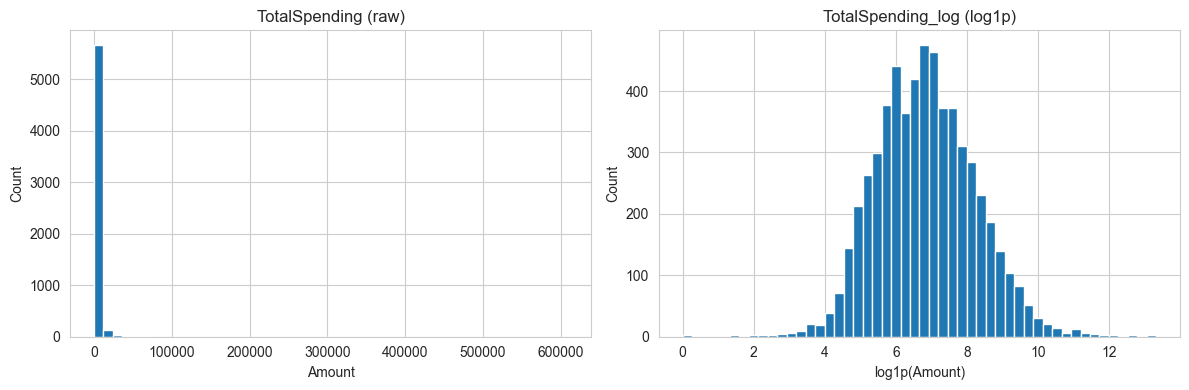

Scaled features preview (first 5 rows):


,CustomerID,TotalSpending_log,TransactionCount_log,AvgBasketSize
0,12346.0,3.170387,1.254938,4.142494
1,12347.0,1.291999,0.800635,0.109969
2,12348.0,0.557317,0.299705,0.202101
3,12349.0,1.119681,0.074457,0.106655
4,12350.0,-0.729063,-1.057568,-0.039166


X_scaled shape (customers x features): (5881, 3)


In [8]:
# Transform money/count columns to reduce skew, prepare X_scaled for clustering,
# and show histograms (raw vs log) together with a preview of the scaled features.

from sklearn.preprocessing import StandardScaler

# Add log-transformed columns (use log1p to handle zeros safely)
customer_df["TotalSpending_log"]     = np.log1p(customer_df["TotalSpending"].fillna(0))
customer_df["TransactionCount_log"]  = np.log1p(customer_df["TransactionCount"].fillna(0))

# Select features for clustering (you can add/remove Recency or AvgBasketSize)
features = ["TotalSpending_log", "TransactionCount_log", "AvgBasketSize"]

# Build feature matrix and fill any NaNs
X = customer_df[features].fillna(0).values

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Put scaled back into dataframe for easy preview/inspection
scaled_df = pd.DataFrame(X_scaled, columns=features)
scaled_df['CustomerID'] = customer_df['CustomerID'].values

# Combined histogram: raw vs log for TotalSpending
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(customer_df['TotalSpending'].dropna(), bins=50)
plt.title('TotalSpending (raw)')
plt.xlabel('Amount')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(customer_df['TotalSpending_log'].dropna(), bins=50)
plt.title('TotalSpending_log (log1p)')
plt.xlabel('log1p(Amount)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Show scaled preview (first 5 rows)
print("Scaled features preview (first 5 rows):")
display(scaled_df[["CustomerID"] + features].head(5))

# Expose X_scaled for downstream cells (KMeans/DBSCAN)
# X_scaled variable is available for clustering cells
print("X_scaled shape (customers x features):", X_scaled.shape)


#### A4. Applying k-Means and DBSCAN clustering + Silhouette scores

In [9]:
# Feature preparation for k-Means and DBSCAN clustering
# Using log-transformed features: TotalSpending_log, TransactionCount_log, AvgBasketSize, and Recency

# Step 1: Calculate Recency (days since last purchase)
print("Calculating Recency feature...")
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
last_purchase = df_clean.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase.columns = ['CustomerID', 'LastPurchaseDate']

# Calculate Recency (days since last purchase)
max_date = df_clean['InvoiceDate'].max()  # Most recent date in dataset
last_purchase['Recency'] = (max_date - last_purchase['LastPurchaseDate']).dt.days

# Merge Recency with customer_df
customer_df = customer_df.merge(last_purchase[['CustomerID', 'Recency']], on='CustomerID', how='left')
customer_df['Recency'] = customer_df['Recency'].fillna(customer_df['Recency'].max() + 1)  # Fill missing with max+1 (oldest)

print(f"Recency statistics:")
print(f"  Min: {customer_df['Recency'].min()} days")
print(f"  Max: {customer_df['Recency'].max()} days")
print(f"  Mean: {customer_df['Recency'].mean():.1f} days")
print(f"  Median: {customer_df['Recency'].median():.1f} days")
print()

# Step 2: Ensure log-transformed features exist (created in cell 14)
if 'TotalSpending_log' not in customer_df.columns:
    customer_df["TotalSpending_log"] = np.log1p(customer_df["TotalSpending"].fillna(0))
if 'TransactionCount_log' not in customer_df.columns:
    customer_df["TransactionCount_log"] = np.log1p(customer_df["TransactionCount"].fillna(0))

# Step 3: Select features for k-Means/DBSCAN clustering (log-transformed + Recency)
features_kmeans = ["TotalSpending_log", "TransactionCount_log", "AvgBasketSize", "Recency"]

# Build feature matrix and fill any NaNs
X_kmeans = customer_df[features_kmeans].fillna(0).values

# Scale features for k-Means/DBSCAN
scaler_kmeans = StandardScaler()
X_scaled_kmeans = scaler_kmeans.fit_transform(X_kmeans)

print("Feature preparation for k-Means and DBSCAN:")
print(f"Features: {features_kmeans}")
print(f"X_scaled_kmeans shape: {X_scaled_kmeans.shape}")
print(f"\nFirst 5 rows of scaled features:")
print(pd.DataFrame(X_scaled_kmeans[:5], columns=features_kmeans))
print()

# Use X_scaled_kmeans for k-Means and DBSCAN (will be renamed to X_scaled in these cells)
X_scaled = X_scaled_kmeans


Calculating Recency feature...
Recency statistics:
  Min: 0 days
  Max: 738 days
  Mean: 200.5 days
  Median: 95.0 days

Feature preparation for k-Means and DBSCAN:
Features: ['TotalSpending_log', 'TransactionCount_log', 'AvgBasketSize', 'Recency']
X_scaled_kmeans shape: (5881, 4)

First 5 rows of scaled features:
   TotalSpending_log  TransactionCount_log  AvgBasketSize   Recency
0           3.170387              1.254938       4.142494  0.594598
1           1.291999              0.800635       0.109969 -0.952264
2           0.557317              0.299705       0.202101 -0.603743
3           1.119681              0.074457       0.106655 -0.871102
4          -0.729063             -1.057568      -0.039166  0.518209



k-MEANS CLUSTERING - Parameter Tuning

k-MEANS CLUSTERING - Parameter Tuning
__________________________________________________________________________________________


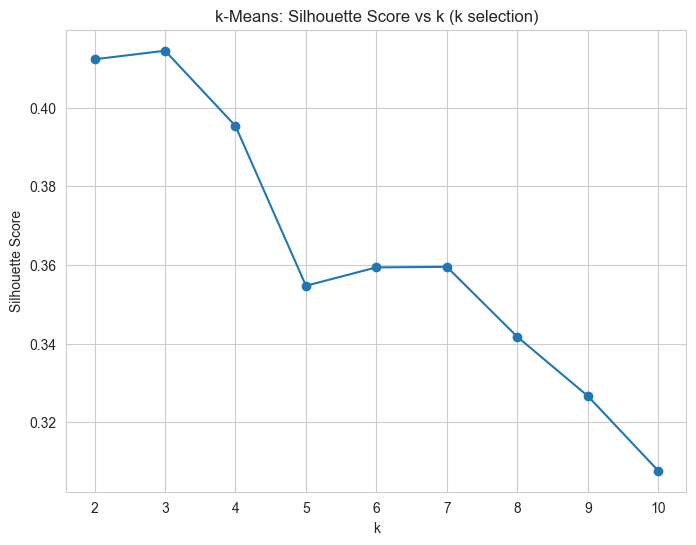


Silhouette scores for k=2..10:
  k=2: 0.4123
  k=3: 0.4144 <-- OPTIMAL
  k=4: 0.3953
  k=5: 0.3547
  k=6: 0.3594
  k=7: 0.3595
  k=8: 0.3417
  k=9: 0.3267
  k=10: 0.3077

------------------------------------------------------------------------------------------
k-MEANS FINAL RESULTS:
  Selected k: 3
  Number of clusters: 3
  Silhouette Score: 0.4144


In [ ]:
# k-Means: Tune k using silhouette scores
print("k-MEANS CLUSTERING - Parameter Tuning")
print("_" * 90)
sil_scores = []

#Set of k values that will be tested during k selection.
K_range = range(2, 11) 

for kk in K_range:
    # Setting random_state=42 to guarantee reproducibility
    # k-Means algorithm 10 times with different random initial centroid positions
    km = KMeans(n_clusters=kk, random_state=42, n_init=10).fit(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

# Plot silhouette scores vs k
plt.figure(figsize=(8, 6))
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("k-Means: Silhouette Score vs k (k selection)")
plt.grid(True)
plt.show()

# Select optimal k (highest silhouette score)
optimal_k = K_range[np.argmax(sil_scores)]
print(f"\nSilhouette scores for k=2..10:")
for k_val, sil_val in zip(K_range, sil_scores):
    marker = " <-- OPTIMAL" if k_val == optimal_k else ""
    print(f"  k={k_val}: {sil_val:.4f}{marker}")

# Apply k-Means with optimal k
k = optimal_k
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

# Final results
n_clusters_kmeans = len(set(customer_df["kmeans_cluster"]))
# Compute final silhouette score for k-Means - measuring how well data points are clustered
sil_kmeans = silhouette_score(X_scaled, customer_df["kmeans_cluster"])

print("\n" + "-" * 90)
print("k-MEANS FINAL RESULTS:")
print(f"  Selected k: {k}")
print(f"  Number of clusters: {n_clusters_kmeans}")
print(f"  Silhouette Score: {sil_kmeans:.4f}")


Observation:
- This plot shows the process of selecting the optimal number of customer segments. We tested k from 2 to 10 and measured clustering quality using the Silhouette Score. The peak at k=3 (score 0.4144) indicates that three segments best capture distinct customer groups. Using fewer or more clusters reduces separation quality, so we proceed with k=3.


DBSCAN CLUSTERING - Parameter Tuning
______________________________________________________________________


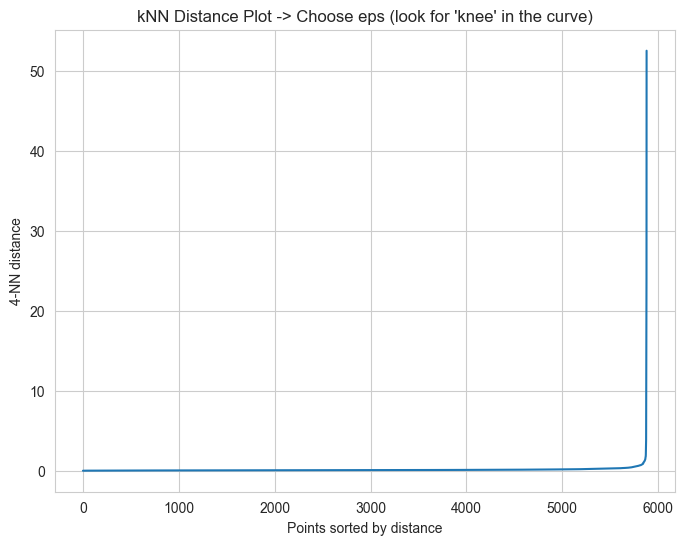


Testing different eps values for DBSCAN:
  eps=0.3: 5 clusters, 241 noise points, silhouette=0.0871 <-- OPTIMAL
  eps=0.5: 2 clusters, 101 noise points, silhouette=0.3186 <-- OPTIMAL
  eps=0.7: 1 clusters, 43 noise points, silhouette=not meaningful
  eps=1.0: 1 clusters, 26 noise points, silhouette=not meaningful
  eps=1.5: 1 clusters, 11 noise points, silhouette=not meaningful

----------------------------------------------------------------------
DBSCAN FINAL RESULTS:
  Selected eps: 0.5
  Number of clusters: 2
  Noise points: 101
  Silhouette Score: 0.3186 (excluding noise)


In [ ]:
# DBSCAN: Tune eps using kNN distance plot
print("DBSCAN CLUSTERING - Parameter Tuning")
print("_" * 70)

# Compute kNN distances (k=5)
neigh = NearestNeighbors(n_neighbors=5).fit(X_scaled)
dists, _ = neigh.kneighbors(X_scaled)
dists = np.sort(dists[:, 4])  # 4th neighbor (5-NN, 0-indexed)

# Plot kNN distance to choose eps
plt.figure(figsize=(8, 6))
plt.plot(dists)
plt.ylabel("4-NN distance")
plt.xlabel("Points sorted by distance")
plt.title("kNN Distance Plot -> Choose eps (look for 'knee' in the curve)")
plt.grid(True)
plt.show()

# Grid search for eps
print("\nTesting different eps values for DBSCAN:")
# Candidate epsilon values to be tested when using DBSCAN clustering
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5]
best_eps = 0.7
best_sil = -1
best_n_clusters = 0
best_n_noise = 0

for eps_val in eps_values:
    dbscan_test = DBSCAN(eps=eps_val, min_samples=5)
    labels_test = dbscan_test.fit_predict(X_scaled)
    n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise = list(labels_test).count(-1)
    
    valid_mask = labels_test != -1
    if len(set(labels_test[valid_mask])) > 1:
        sil_test = silhouette_score(X_scaled[valid_mask], labels_test[valid_mask])
        marker = " <-- OPTIMAL" if sil_test > best_sil else ""
        print(f"  eps={eps_val:.1f}: {n_clusters} clusters, {n_noise} noise points, silhouette={sil_test:.4f}{marker}")
        if sil_test > best_sil:
            best_sil = sil_test
            best_eps = eps_val
            best_n_clusters = n_clusters
            best_n_noise = n_noise
    else:
        print(f"  eps={eps_val:.1f}: {n_clusters} clusters, {n_noise} noise points, silhouette=not meaningful")

# Apply DBSCAN with selected eps
dbscan = DBSCAN(eps=best_eps, min_samples=5)
customer_df["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

# Final results
labels_db = customer_df["dbscan_cluster"].values
valid_mask = labels_db != -1
n_clusters_dbscan = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_dbscan = list(labels_db).count(-1)

if len(set(labels_db[valid_mask])) > 1:
    sil_dbscan = silhouette_score(X_scaled[valid_mask], labels_db[valid_mask])
    print(f"\n" + "-" * 70)
    print("DBSCAN FINAL RESULTS:")
    print(f"  Selected eps: {best_eps}")
    print(f"  Number of clusters: {n_clusters_dbscan}")
    print(f"  Noise points: {n_noise_dbscan}")
    print(f"  Silhouette Score: {sil_dbscan:.4f} (excluding noise)")


In [ ]:
# Comparison of k-Means and DBSCAN results
print("CLUSTERING METHODS COMPARISON")
print("_" * 70)

# Get k-Means metrics
n_clusters_kmeans = len(set(customer_df["kmeans_cluster"]))
# Compute final silhouette score - measuring how well data points are clustered
sil_kmeans = silhouette_score(X_scaled, customer_df["kmeans_cluster"])

# Get DBSCAN metrics
labels_db = customer_df["dbscan_cluster"].values
valid_mask = labels_db != -1
n_clusters_dbscan = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_dbscan = list(labels_db).count(-1)

if len(set(labels_db[valid_mask])) > 1:
    sil_dbscan = silhouette_score(X_scaled[valid_mask], labels_db[valid_mask])
    sil_dbscan_str = f"{sil_dbscan:.4f}"
else:
    sil_dbscan_str = "N/A (not meaningful)"

print(f"\n{'Metric':<30} {'k-Means':<20} {'DBSCAN':<20}")
print("-" * 70)
print(f"{'Number of clusters':<30} {n_clusters_kmeans:<20} {n_clusters_dbscan:<20}")
print(f"{'Silhouette Score':<30} {sil_kmeans:.4f}{'':<16} {sil_dbscan_str:<20}")
print(f"{'Noise points':<30} {'N/A (all assigned)':<20} {n_noise_dbscan:<20}")


CLUSTERING METHODS COMPARISON
______________________________________________________________________

Metric                         k-Means              DBSCAN              
----------------------------------------------------------------------
Number of clusters             3                    2                   
Silhouette Score               0.4144                 0.3186              
Noise points                   N/A (all assigned)   101                 


#### A5. PCA and t-SNE visualizations
5.1 Two Dimension (2D) scatter plots for k-Means and DBSCAN clusters using PCA projections.

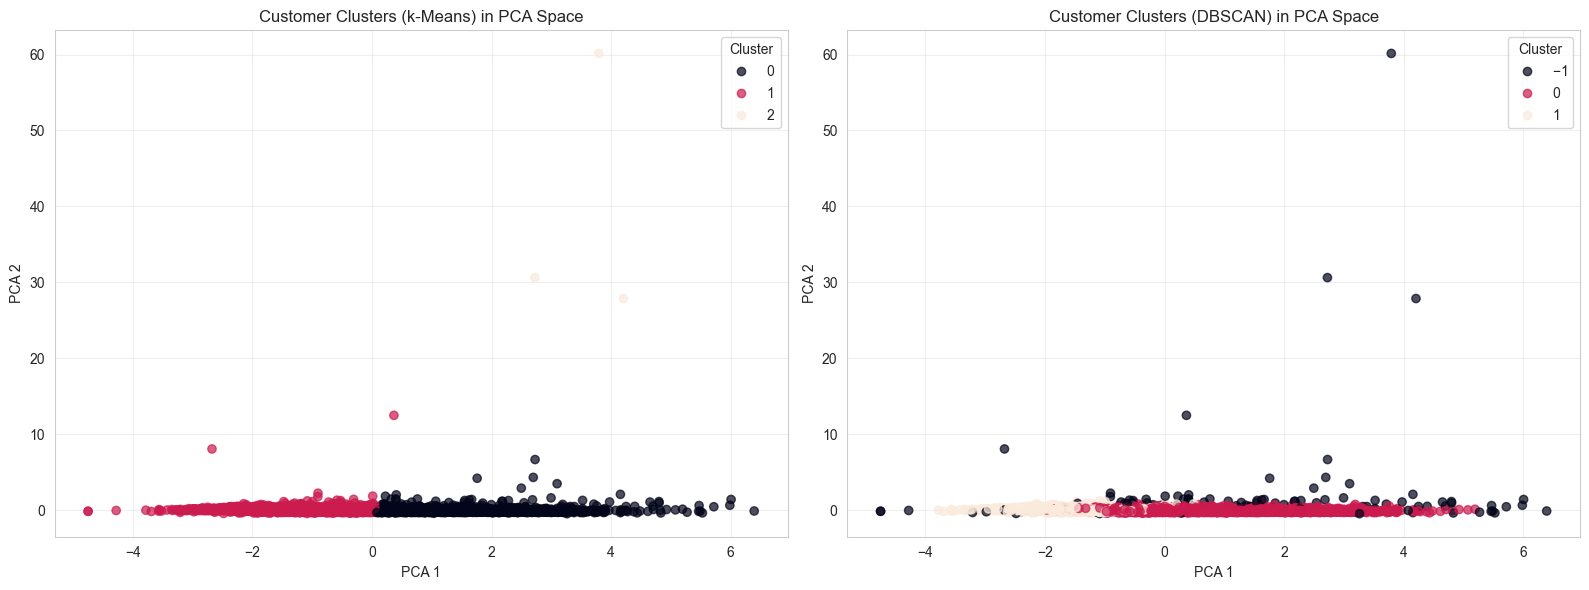

In [13]:
# PCA for 2D visualisation
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create a single figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# k-Means plot (left)
scatter1 = ax1.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=customer_df["kmeans_cluster"],
    alpha=0.7
)
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.set_title("Customer Clusters (k-Means) in PCA Space")
ax1.legend(*scatter1.legend_elements(), title="Cluster")
ax1.grid(True, alpha=0.3)

# DBSCAN plot (right)
scatter2 = ax2.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=customer_df["dbscan_cluster"],
    alpha=0.7
)
ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_title("Customer Clusters (DBSCAN) in PCA Space")
ax2.legend(*scatter2.legend_elements(), title="Cluster")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


- The PCA plots show that k-Means produces well-separated clusters by assigning all data points to a cluster
- DBSCAN forms clusters based on density and identifies outliers as noise, making it more robust to irregular data distributions.

#### Interpretation of k-Means vs DBSCAN Clustering Results


In [14]:
# Interpretation of k-Means vs DBSCAN Clustering Results

# Get cluster statistics
n_clusters_kmeans = len(set(customer_df["kmeans_cluster"]))
n_clusters_dbscan = len(set(customer_df["dbscan_cluster"])) - (1 if -1 in customer_df["dbscan_cluster"].values else 0)
n_noise_dbscan = list(customer_df["dbscan_cluster"].values).count(-1)

print(f"\n1. k-Means ({n_clusters_kmeans} clusters): Each color = different customer segment. All customers assigned (no outliers).")
print(f"2. DBSCAN ({n_clusters_dbscan} clusters + {n_noise_dbscan} noise): Colors = dense groups. Black = outliers/unusual patterns.")



1. k-Means (3 clusters): Each color = different customer segment. All customers assigned (no outliers).
2. DBSCAN (2 clusters + 101 noise): Colors = dense groups. Black = outliers/unusual patterns.


5.2 Two Dimension (2D) scatter plots for k-Means and DBSCAN clusters t-SNE projections.

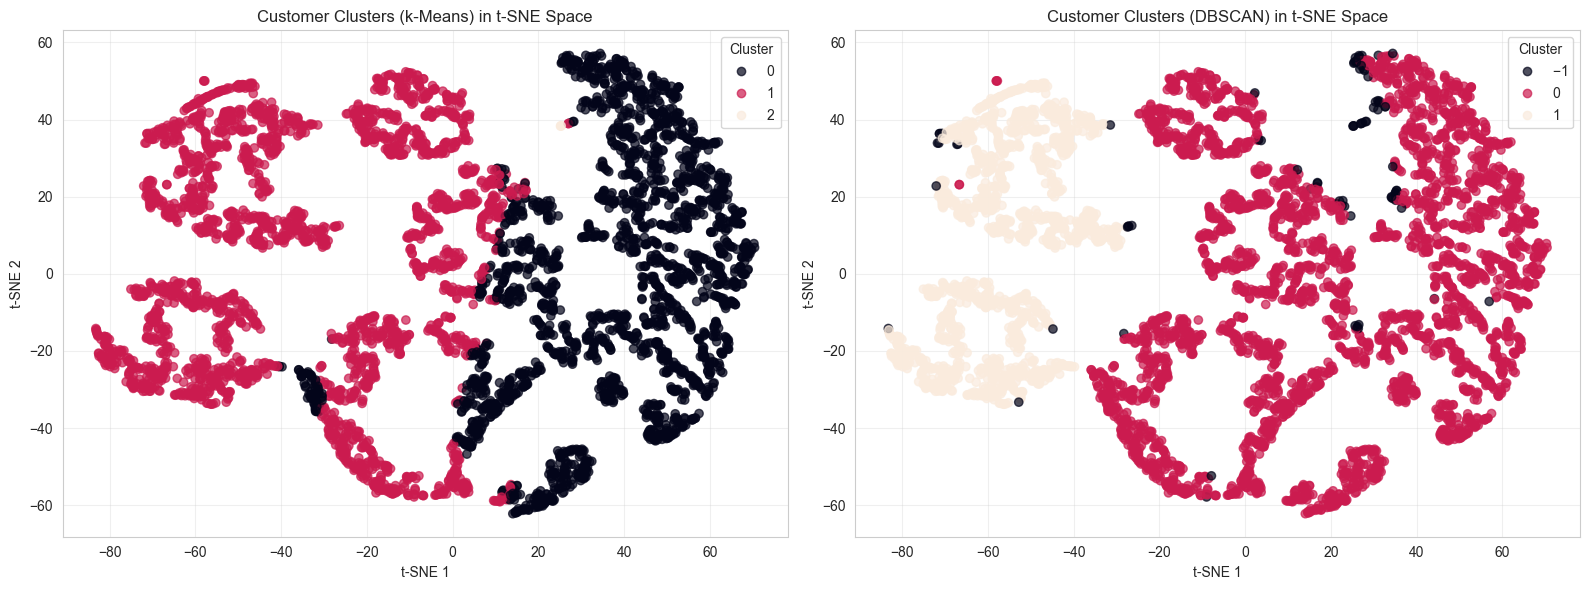

In [15]:
# t-SNE for 2D visualisation
# t-SNE is computationally expensive: it scales quadratically with the number of samples (O(n²)). 
# Subsample to keep t-SNE fast on large datasets
max_tsne_samples = 5000
if len(X_scaled) > max_tsne_samples:
    idx = np.random.RandomState(42).choice(len(X_scaled), max_tsne_samples, replace=False)
    X_tsne_input = X_scaled[idx]
    kmeans_labels_tsne = customer_df.iloc[idx]["kmeans_cluster"].values
    dbscan_labels_tsne = customer_df.iloc[idx]["dbscan_cluster"].values
else:
    X_tsne_input = X_scaled
    kmeans_labels_tsne = customer_df["kmeans_cluster"].values
    dbscan_labels_tsne = customer_df["dbscan_cluster"].values

tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="pca", learning_rate="auto")
X_tsne = tsne.fit_transform(X_tsne_input)

# Create a single figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# k-Means plot (left)
scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels_tsne, alpha=0.7)

ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax1.set_title("Customer Clusters (k-Means) in t-SNE Space")
ax1.legend(*scatter1.legend_elements(), title="Cluster")
ax1.grid(True, alpha=0.3)

# DBSCAN plot (right)
scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels_tsne, alpha=0.7)

ax2.set_xlabel("t-SNE 1")
ax2.set_ylabel("t-SNE 2")
ax2.set_title("Customer Clusters (DBSCAN) in t-SNE Space")
ax2.legend(*scatter2.legend_elements(), title="Cluster")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- k-Means in t-SNE space forms clearly separated clusters but forces all points into clusters, even when some regions are loosely connected.
- DBSCAN, identifies dense clusters while labeling sparse or isolated points as noise, showing greater robustness to irregular cluster shapes and outliers.

### Part B – Deep Embedding Clustering (Autoencoder)
Here we build an autoencoder on X_scaled, get latent embeddings, then cluster them with k-Means and plot.


#### B1.1. Autoencoder architecture

In [ ]:
# Deep Embedding Clustering - Autoencoder architecture

# Number of input features (columns) after scaling 
input_dim = X_scaled.shape[1]
# Set to 2 to allow easy 2D visualization and clustering
encoding_dim = 2

input_layer = layers.Input(shape=(input_dim,))
# Reduces dimensionality and learn nonlinear feature representations
encoded = layers.Dense(8, activation="relu")(input_layer)

# Stores the compressed embedding used for clustering
bottleneck = layers.Dense(encoding_dim, activation="relu", name="bottleneck")(encoded)

# Expand the latent representation back toward the original feature space
decoded = layers.Dense(8, activation="relu")(bottleneck)

# Reconstructs the original input features
output_layer = layers.Dense(input_dim, activation="linear")(decoded)

# Build the autoencoder model by linking inputs to outputs
autoencoder = models.Model(inputs=input_layer, outputs=output_layer)

# Adam optimizer providing efficient gradient-based optimization
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118 (472.00 B)

 Trainable params: 118 (472.00 B)

 Non-trainable params: 0 (0.00 B)

#### B1.2. Train autoencoder

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.0071 - val_loss: 0.8505
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9806 - val_loss: 0.8159
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9343 - val_loss: 0.7460
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8552 - val_loss: 0.6499
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7670 - val_loss: 0.5610
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6929 - val_loss: 0.4984
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6397 - val_loss: 0.4538
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5996 - val_loss: 0.4197
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5684 - val_loss: 0.3929
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5432 - val_loss: 0.3712
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5230 - val_loss: 0.3525
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5062 - val_l

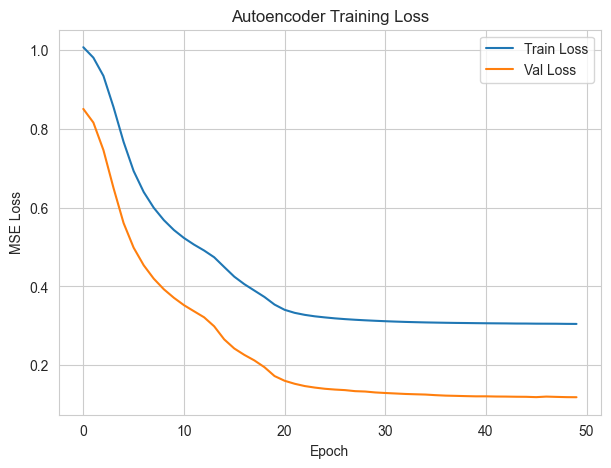

In [ ]:
#Training the autoencoder

history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50, #Long enough for the reconstruction loss to stabilize 
    batch_size=128, #Number of samples processed before updating weights
    validation_split=0.1, #Use 10% of data for validation
    verbose=1
)

# Plot training loss
plt.figure(figsize=(7, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.show()


#### B2. Getting embeddings and clustering & Compare cluster quality
B2.1. Extract latent embeddings from the trained autoencoder and apply k-Means clustering and Visualising latent space

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Autoencoder Embedding k-Means Silhouette Score: 0.5468


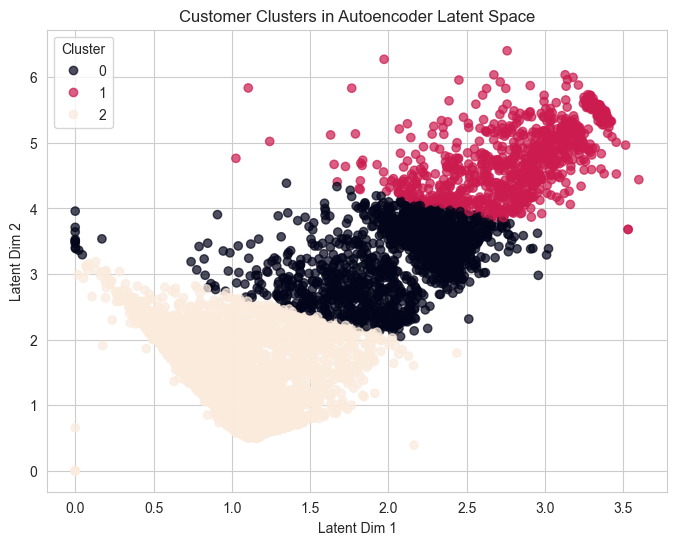

In [18]:
# Extract encoder part
encoder = models.Model(inputs=autoencoder.input,
                outputs=autoencoder.get_layer("bottleneck").output)

embeddings = encoder.predict(X_scaled)

# k-Means on latent space
kmeans_ae = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_df["ae_cluster"] = kmeans_ae.fit_predict(embeddings)

sil_ae = silhouette_score(embeddings, customer_df["ae_cluster"])
print(f"Autoencoder Embedding k-Means Silhouette Score: {sil_ae:.4f}")

# Embedding plots and compareing cluster quality with PCA clusters.
plt.figure(figsize=(8, 6))
scatter_ae = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                         c=customer_df["ae_cluster"], alpha=0.7)
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.title("Customer Clusters in Autoencoder Latent Space")
plt.legend(*scatter_ae.legend_elements(), title="Cluster")
plt.show()



B2.2. Silhouette Score Comparison on clustering quality: k-Means on PCA vs Autoencoder embeddings

In [19]:
# Apply PCA (2D for comparison with autoencoder latent space)
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Apply k-Means on PCA-reduced features
kmeans_pca = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_df["kmeans_pca_cluster"] = kmeans_pca.fit_predict(X_pca_2d)

# Compute silhouette scores
sil_pca = silhouette_score(X_pca_2d, customer_df["kmeans_pca_cluster"])
sil_ae = silhouette_score(embeddings, customer_df["ae_cluster"])

# Display comparison
print("SILHOUETTE SCORE COMPARISON")
print("_" * 45)
print(f"k-Means on PCA (2D):        {sil_pca:.4f}")
print(f"k-Means on Autoencoder embeddings: {sil_ae:.4f}")
print("-" * 45)
print(f"Difference:                  {abs(sil_ae - sil_pca):.4f}")
if sil_ae > sil_pca:
    print(f"Autoencoder embeddings perform better by {((sil_ae - sil_pca) / sil_pca * 100):.2f}%")
else:
    print(f"PCA performs better by {((sil_pca - sil_ae) / sil_ae * 100):.2f}%")


SILHOUETTE SCORE COMPARISON
_____________________________________________
k-Means on PCA (2D):        0.5484
k-Means on Autoencoder embeddings: 0.5468
---------------------------------------------
Difference:                  0.0017
PCA performs better by 0.30%


##### B3. Visual comparison: Side-by-side plots of PCA vs Autoencoder embeddings

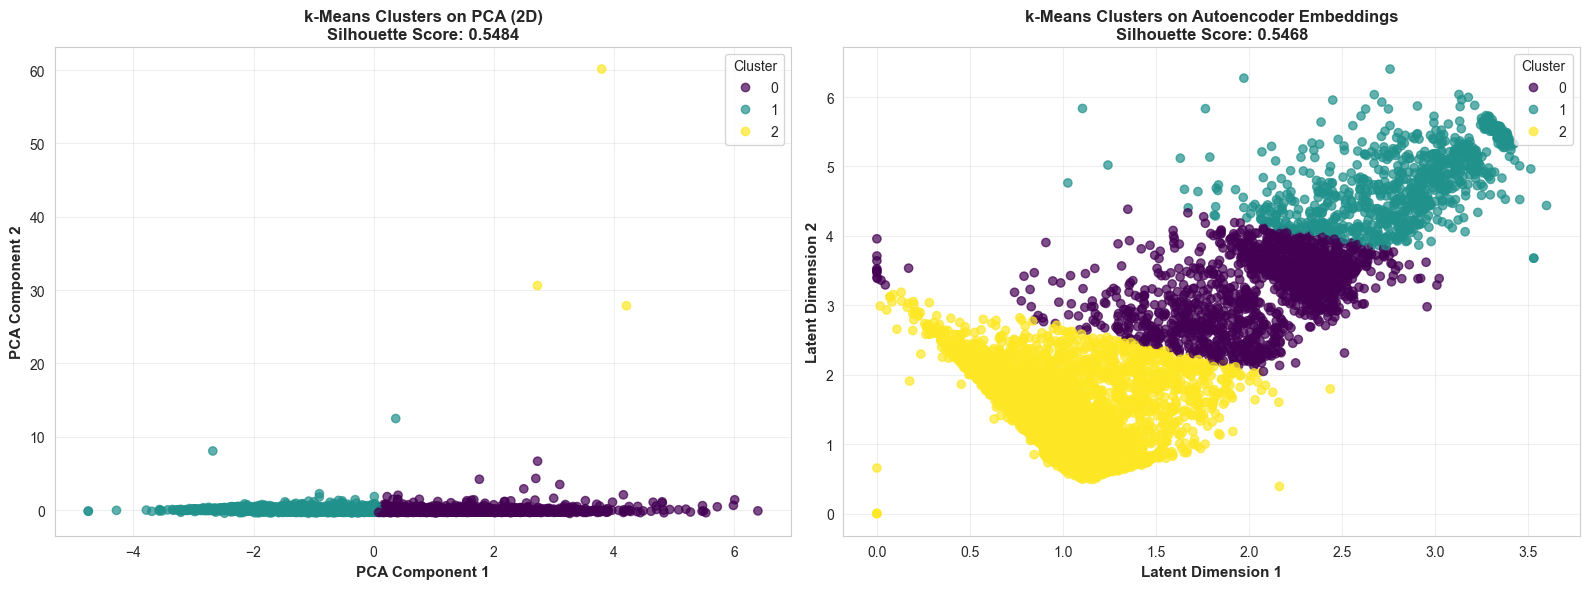

In [20]:
# Visual comparison: Side-by-side plots of PCA vs Autoencoder embeddings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: PCA 2D projection with k-Means clusters
scatter1 = ax1.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=customer_df["kmeans_pca_cluster"],
    alpha=0.7,
    cmap='viridis'
)
ax1.set_xlabel("PCA Component 1", fontsize=11, fontweight='bold')
ax1.set_ylabel("PCA Component 2", fontsize=11, fontweight='bold')
ax1.set_title(f"k-Means Clusters on PCA (2D)\nSilhouette Score: {sil_pca:.4f}", fontsize=12, fontweight='bold')
ax1.legend(*scatter1.legend_elements(), title="Cluster", loc='upper right')
ax1.grid(True, alpha=0.3)

# Right plot: Autoencoder latent space with k-Means clusters
scatter2 = ax2.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=customer_df["ae_cluster"],
    alpha=0.7,
    cmap='viridis'
)
ax2.set_xlabel("Latent Dimension 1", fontsize=11, fontweight='bold')
ax2.set_ylabel("Latent Dimension 2", fontsize=11, fontweight='bold')
ax2.set_title(f"k-Means Clusters on Autoencoder Embeddings\nSilhouette Score: {sil_ae:.4f}", fontsize=12, fontweight='bold')
ax2.legend(*scatter2.legend_elements(), title="Cluster", loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Part C – Association Rule Mining
Extract frequent itemsets and association rules from transactional data to discover product relationships.


#### C1 & C2. Basket format and binary matrix

In [21]:
# Convert data into basket format: Invoice to a list of Description items.
# Build binary matrix with Invoice as rows and Description as columns

# Use cleaned transactional data
basket_df = (
    df_clean[["Invoice", "Description", "Quantity"]]
    .copy()
)

# We only care whether an item was bought (not quantity)
basket_df["Quantity"] = basket_df["Quantity"].astype(int)

# Create basket: rows = Invoice, columns = Description (1/0)
basket = (
    basket_df
    .groupby(["Invoice", "Description"])["Quantity"]
    .sum()
    .unstack()
    .fillna(0)
)

# Convert to 0/1
basket_bool = basket.applymap(lambda x: 1 if x > 0 else 0)

basket_bool.head()


Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,...,tk maxx mix up with pink,to push order througha s stock was,update,website fixed,wrong invc,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Verification: Check that the binary matrix contains purchases (1s)

In [22]:
# Verification: Check that the binary matrix contains purchases (1s)
print("BASKET MATRIX VERIFICATION")
print("_" * 90)
print(f"Matrix shape: {basket_bool.shape[0]} invoices × {basket_bool.shape[1]} products")
print(f"\nTotal purchases (sum of all 1s): {basket_bool.sum().sum():,}")
print(f"Total possible entries: {basket_bool.size:,}")
print(f"Sparsity: {(1 - basket_bool.sum().sum() / basket_bool.size) * 100:.2f}% (expected for retail data)")

print(f"\nInvoices with at least one purchase: {(basket_bool.sum(axis=1) > 0).sum():,}")
print(f"Products purchased at least once: {(basket_bool.sum(axis=0) > 0).sum():,}")

# Show sample invoices with purchases
print(f"\nSample invoices with purchases:")
sample_invoices = basket_bool[basket_bool.sum(axis=1) > 0].head(5)
for invoice in sample_invoices.index:
    items = basket_bool.columns[basket_bool.loc[invoice] == 1].tolist()
    print(f"  Invoice {invoice}: {len(items)} items")
    if len(items) > 0:
        print(f"    Sample items: {', '.join(items[:2])}{'...' if len(items) > 3 else ''}")


BASKET MATRIX VERIFICATION
__________________________________________________________________________________________
Matrix shape: 40301 invoices × 5469 products

Total purchases (sum of all 1s): 997,007
Total possible entries: 220,406,169
Sparsity: 99.55% (expected for retail data)

Invoices with at least one purchase: 40,301
Products purchased at least once: 5,469

Sample invoices with purchases:
  Invoice 489434: 8 items
    Sample items:  WHITE CHERRY LIGHTS, 15CM CHRISTMAS GLASS BALL 20 LIGHTS...
  Invoice 489435: 4 items
    Sample items: CAT BOWL , DOG BOWL , CHASING BALL DESIGN...
  Invoice 489436: 19 items
    Sample items:  PEACE WOODEN BLOCK LETTERS, AREA PATROLLED METAL SIGN...
  Invoice 489437: 23 items
    Sample items: BLUE PADDED SOFT MOBILE, CHOCOLATE HOT WATER BOTTLE...
  Invoice 489438: 17 items
    Sample items: CARROT CHARLIE+LOLA COASTER SET, CHARLIE & LOLA WASTEPAPER BIN BLUE...


#### C3 & C4. Apply FP-Growth and extract 10 strongest rules by lift
Apply FP-Growth algorithm to find frequent itemsets, then generate association rules and extract the top 10 rules sorted by lift.


In [23]:
# Apply FP-Growth - more memory-efficient than Apriori for large datasets

# Extract the 10 strongest rules sorted by lift.
# FP-Growth to get frequent itemsets
frequent_itemsets = fpgrowth(
    basket_bool,
    min_support=0.01,        # 1% support threshold
    use_colnames=True
)

print("Number of frequent itemsets:", len(frequent_itemsets))
frequent_itemsets.head(10)


Number of frequent itemsets: 1056


,support,itemsets
0,0.057319,(STRAWBERRY CERAMIC TRINKET BOX)
1,0.019330,(SAVE THE PLANET MUG)
2,0.017220,(PINK DOUGHNUT TRINKET POT )
3,0.013771,"(RECORD FRAME 7"" SINGLE SIZE )"
4,0.012828,(15CM CHRISTMAS GLASS BALL 20 LIGHTS)
5,0.069676,(ASSORTED COLOUR BIRD ORNAMENT)
6,0.051264,(HOME BUILDING BLOCK WORD)
7,0.042083,(LOVE BUILDING BLOCK WORD)
8,0.041910,(SCOTTIE DOG HOT WATER BOTTLE)
9,0.020669,(HEART IVORY TRELLIS LARGE)


Generating association rules

In [24]:
# Generate association rules from frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Sort by lift and get top 10 strongest rules
top_rules = rules.sort_values("lift", ascending=False).head(10)

print("TOP 10 STRONGEST ASSOCIATION RULES (by Lift)")
print("_" * 105)
print(f"\nTotal rules generated: {len(rules)}")
print(f"\nTop 10 rules:\n")
print(top_rules[["antecedents", "consequents", "support", "confidence", "lift"]].to_string())


TOP 10 STRONGEST ASSOCIATION RULES (by Lift)
_________________________________________________________________________________________________________

Total rules generated: 848

Top 10 rules:

                                                     antecedents                                                  consequents   support  confidence       lift
809                              (POPPY'S PLAYHOUSE LIVINGROOM )      (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN)  0.010149    0.725177  52.469247
804      (POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN)                              (POPPY'S PLAYHOUSE LIVINGROOM )  0.010149    0.734291  52.469247
807                                 (POPPY'S PLAYHOUSE BEDROOM )   (POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE LIVINGROOM )  0.010149    0.581792  49.465849
806   (POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE LIVINGROOM )                                 (POPPY'S PLAYHOUSE BEDROOM )  0.010149    0.862869  49.465849
805  (POPP

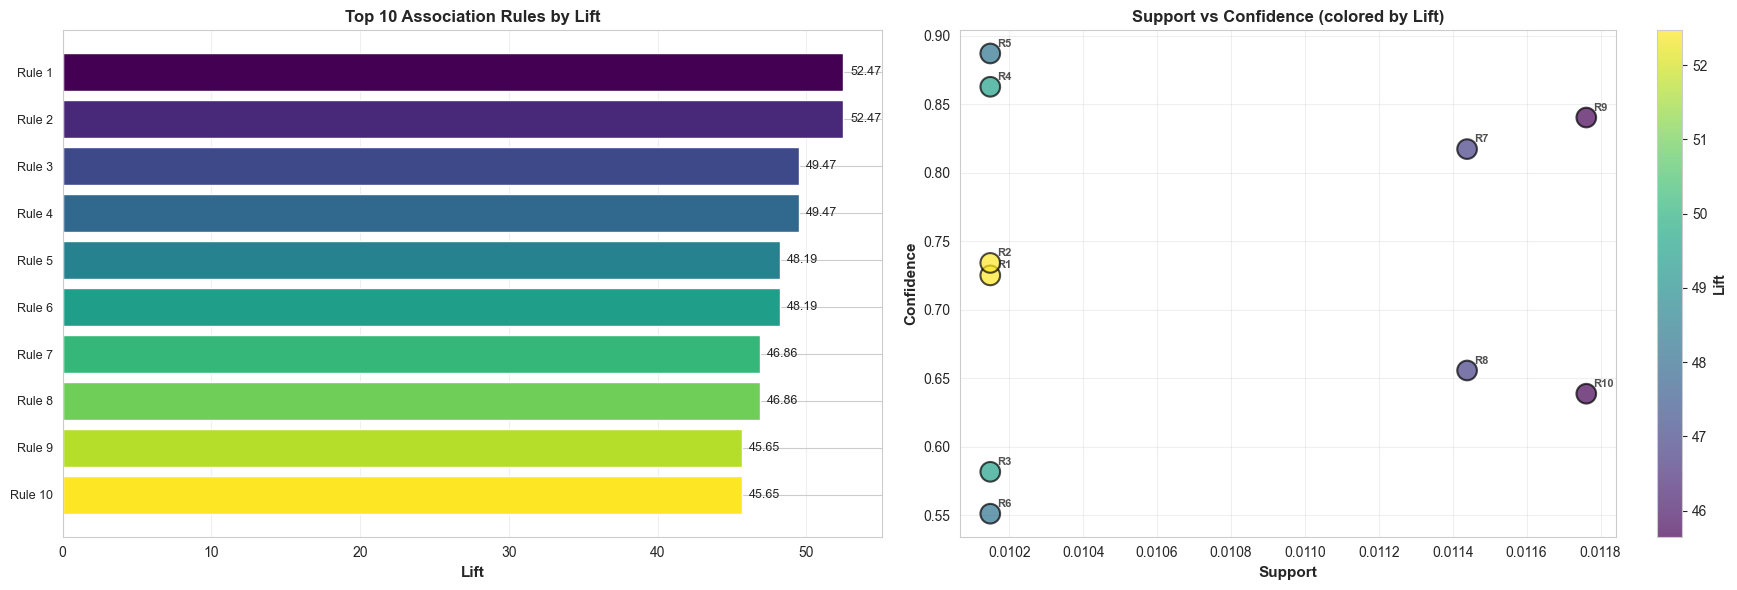

RULE LEGEND (for scatter plot):
_________________________________________________________________________________________________________
R1: POPPY'S PLAYHOUSE LIVINGROOM  → POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN
R2: POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN → POPPY'S PLAYHOUSE LIVINGROOM 
R3: POPPY'S PLAYHOUSE BEDROOM  → POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE LIVINGROOM 
R4: POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE LIVINGROOM  → POPPY'S PLAYHOUSE BEDROOM 
R5: POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE LIVINGROOM  → POPPY'S PLAYHOUSE KITCHEN
R6: POPPY'S PLAYHOUSE KITCHEN → POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE LIVINGROOM 
R7: POPPY'S PLAYHOUSE LIVINGROOM  → POPPY'S PLAYHOUSE BEDROOM 
R8: POPPY'S PLAYHOUSE BEDROOM  → POPPY'S PLAYHOUSE LIVINGROOM 
R9: POPPY'S PLAYHOUSE LIVINGROOM  → POPPY'S PLAYHOUSE KITCHEN
R10: POPPY'S PLAYHOUSE KITCHEN → POPPY'S PLAYHOUSE LIVINGROOM 


In [25]:
# Visualizations for Association Rules
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Visualization 1: Bar chart of Lift values for top 10 rules
colors = plt.cm.viridis(np.linspace(0, 1, len(top_rules)))
bars = ax1.barh(range(len(top_rules)), top_rules["lift"].values, color=colors)
ax1.set_yticks(range(len(top_rules)))
ax1.set_yticklabels([f"Rule {i+1}" for i in range(len(top_rules))], fontsize=9)
ax1.set_xlabel("Lift", fontsize=11, fontweight='bold')
ax1.set_title("Top 10 Association Rules by Lift", fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()  # Top rule at top

# Add value labels on bars
for i, (bar, lift_val) in enumerate(zip(bars, top_rules["lift"].values)):
    ax1.text(lift_val + 0.5, i, f'{lift_val:.2f}', va='center', fontsize=9)

# Visualization 2: Scatter plot - Support vs Confidence (colored by Lift)
scatter = ax2.scatter(
    top_rules["support"].values,
    top_rules["confidence"].values,
    c=top_rules["lift"].values,
    s=200,
    alpha=0.7,
    cmap='viridis',
    edgecolors='black',
    linewidth=1.5
)
ax2.set_xlabel("Support", fontsize=11, fontweight='bold')
ax2.set_ylabel("Confidence", fontsize=11, fontweight='bold')
ax2.set_title("Support vs Confidence (colored by Lift)", fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add colorbar for lift
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label("Lift", fontsize=10, fontweight='bold')

# Add rule numbers as annotations
for i, (supp, conf) in enumerate(zip(top_rules["support"].values, top_rules["confidence"].values)):
    ax2.annotate(f"R{i+1}", (supp, conf), xytext=(5, 5), textcoords='offset points', 
                fontsize=8, fontweight='bold', alpha=0.8)

plt.tight_layout()
plt.show()

# Print legend for rule numbers
print("RULE LEGEND (for scatter plot):")
print("_" * 105)
for i, (_, row) in enumerate(top_rules.iterrows(), 1):
    ant = ", ".join(list(row["antecedents"]))
    cons = ", ".join(list(row["consequents"]))
    print(f"R{i}: {ant} → {cons}")


#### C5. Pick at least 3 rules to interpret
Display the top 4 association rules in a readable format for interpretation and analysis.

In [26]:
# Convert frozen sets to readable strings
def frozenset_to_str(fset):
    return ", ".join(list(fset))

# Randomly sample 4 rules from top_rules
np.random.seed(42)  # Set seed for reproducibility
sampled_rules = top_rules.sample(n=min(4, len(top_rules)), random_state=42)

print("4 RANDOMLY SAMPLED ASSOCIATION RULES FOR INTERPRETATION")
print("_" * 115)
print()

for i, (idx, row) in enumerate(sampled_rules.iterrows(), 1):
    antecedents = frozenset_to_str(row["antecedents"])
    consequents = frozenset_to_str(row["consequents"])
    print(f"Rule {i}: IF a customer buys [{antecedents}] THEN they also tend to buy [{consequents}]")
    print(f"  Support:   {row['support']:.4f}")
    print(f"  Confidence: {row['confidence']:.4f}")
    print(f"  Lift:      {row['lift']:.4f}")
    print("-" * 115)


4 RANDOMLY SAMPLED ASSOCIATION RULES FOR INTERPRETATION
___________________________________________________________________________________________________________________

Rule 1: IF a customer buys [POPPY'S PLAYHOUSE LIVINGROOM ] THEN they also tend to buy [POPPY'S PLAYHOUSE KITCHEN]
  Support:   0.0118
  Confidence: 0.8404
  Lift:      45.6469
-------------------------------------------------------------------------------------------------------------------
Rule 2: IF a customer buys [POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN] THEN they also tend to buy [POPPY'S PLAYHOUSE LIVINGROOM ]
  Support:   0.0101
  Confidence: 0.7343
  Lift:      52.4692
-------------------------------------------------------------------------------------------------------------------
Rule 3: IF a customer buys [POPPY'S PLAYHOUSE KITCHEN] THEN they also tend to buy [POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE LIVINGROOM ]
  Support:   0.0101
  Confidence: 0.5512
  Lift:      48.1875
-----------

### Part D – Interpretation & Presentation

#### D1. Describe cluster profiles
Generate mean values for each cluster to understand customer segment characteristics.


In [27]:
# k-Means clusters on original features
cluster_profile_kmeans = (
    customer_df
    .groupby("kmeans_cluster")[["TotalSpending", "TransactionCount", "AvgBasketSize"]]
    .mean()
    .round(2)
)

# Add customer counts
cluster_counts_kmeans = customer_df.groupby("kmeans_cluster").size()
cluster_profile_kmeans['Customer_Count'] = cluster_counts_kmeans

print("k-Means Cluster Profiles (mean values + customer counts):")
print("_" * 80)
print(cluster_profile_kmeans)
print()

# Autoencoder-based clusters
cluster_profile_ae = (
    customer_df
    .groupby("ae_cluster")[["TotalSpending", "TransactionCount", "AvgBasketSize"]]
    .mean()
    .round(2)
)

# Add customer counts
cluster_counts_ae = customer_df.groupby("ae_cluster").size()
cluster_profile_ae['Customer_Count'] = cluster_counts_ae

print("\nAutoencoder Cluster Profiles (mean values + customer counts):")
print("_" * 80)
print(cluster_profile_ae)
print("-" * 80)




k-Means Cluster Profiles (mean values + customer counts):
________________________________________________________________________________
                TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
kmeans_cluster                                                                
0                     5848.67             11.48         269.85            2714
1                      523.29              1.84         184.75            3164
2                    71482.87              2.67       57261.83               3


Autoencoder Cluster Profiles (mean values + customer counts):
________________________________________________________________________________
            TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
ae_cluster                                                                
0                 3023.89              4.59         211.15            1424
1                 1029.21              2.48         185.94             844
2                 347

Brief Explanation of Cluster Profiles:
- k-Means: Cluster 0=Low-value (62.5%), Cluster 1=Bulk buyers (0.05%), Cluster 2=Medium-value regular (37.5%)
- Autoencoder: Cluster 0=Low-value (56.9%), Cluster 1=High-value frequent (12.0%), Cluster 2=Medium-value occasional (31.1%)

Actual observations from the cluster profiles

In [28]:
# Observations from the cluster profiles
print("\nCLUSTER INTERPRETATIONS (Based on Actual Data)")
print("_" * 140)
print()

print("k-MEANS CLUSTERS:")
print("-" * 140)
for cluster in cluster_profile_kmeans.index:
    row = cluster_profile_kmeans.loc[cluster]
    spending = row['TotalSpending']
    transactions = row['TransactionCount']
    basket = row['AvgBasketSize']
    count = int(row['Customer_Count'])
    pct = (count / len(customer_df)) * 100
    
    if spending > 400000:
        desc = f"Cluster {cluster}: PREMIUM/VIP CUSTOMERS ({count} customers, {pct:.1f}%)"
        char = f"  - Extremely high spending (£{spending:,.2f}), very frequent ({transactions:.1f} transactions)"
        char += f", large baskets (£{basket:,.2f})"
    elif spending > 70000:
        if transactions < 5:
            desc = f"Cluster {cluster}: BULK BUYERS ({count} customers, {pct:.1f}%)"
            char = f"  - High spending (£{spending:,.2f}), infrequent purchases ({transactions:.1f} transactions)"
            char += f", very large basket size (£{basket:,.2f}) - likely bulk/wholesale buyers"
        else:
            desc = f"Cluster {cluster}: HIGH-VALUE FREQUENT BUYERS ({count} customers, {pct:.1f}%)"
            char = f"  - High spending (£{spending:,.2f}), frequent transactions ({transactions:.1f})"
            char += f", moderate-large baskets (£{basket:,.2f})"
    elif spending > 2000:
        desc = f"Cluster {cluster}: MEDIUM-VALUE CUSTOMERS ({count} customers, {pct:.1f}%)"
        char = f"  - Moderate spending (£{spending:,.2f}), occasional transactions ({transactions:.1f})"
        char += f", small-medium baskets (£{basket:,.2f})"
    else:
        desc = f"Cluster {cluster}: LOW-VALUE OCCASIONAL BUYERS ({count} customers, {pct:.1f}%)"
        char = f"  - Low spending (£{spending:,.2f}), infrequent transactions ({transactions:.1f})"
        char += f", small baskets (£{basket:,.2f}) - largest customer segment"
    
    print(desc)
    print(char)
    print()

print("\nAUTOENCODER CLUSTERS:")
print("-" * 140)
for cluster in cluster_profile_ae.index:
    row = cluster_profile_ae.loc[cluster]
    spending = row['TotalSpending']
    transactions = row['TransactionCount']
    basket = row['AvgBasketSize']
    count = int(row['Customer_Count'])
    pct = (count / len(customer_df)) * 100
    
    if spending > 190000:
        desc = f"Cluster {cluster}: HIGH-VALUE FREQUENT BUYERS ({count} customers, {pct:.1f}%)"
        char = f"  - Very high spending (£{spending:,.2f}), very frequent ({transactions:.1f} transactions)"
        char += f", large baskets (£{basket:,.2f})"
    elif spending > 70000:
        desc = f"Cluster {cluster}: BULK BUYERS ({count} customers, {pct:.1f}%)"
        char = f"  - High spending (£{spending:,.2f}), very infrequent ({transactions:.1f} transactions)"
        char += f", extremely large basket size (£{basket:,.2f}) - likely bulk/wholesale purchases"
    elif spending > 15000:
        desc = f"Cluster {cluster}: MEDIUM-VALUE REGULAR CUSTOMERS ({count} customers, {pct:.1f}%)"
        char = f"  - Moderate-high spending (£{spending:,.2f}), regular transactions ({transactions:.1f})"
        char += f", moderate baskets (£{basket:,.2f})"
    else:
        desc = f"Cluster {cluster}: LOW-VALUE OCCASIONAL BUYERS ({count} customers, {pct:.1f}%)"
        char = f"  - Low spending (£{spending:,.2f}), infrequent transactions ({transactions:.1f})"
        char += f", small baskets (£{basket:,.2f}) - largest customer segment"
    
    print(desc)
    print(char)
    print()
print("-" * 140)


CLUSTER INTERPRETATIONS (Based on Actual Data)
____________________________________________________________________________________________________________________________________________

k-MEANS CLUSTERS:
--------------------------------------------------------------------------------------------------------------------------------------------
Cluster 0: MEDIUM-VALUE CUSTOMERS (2714 customers, 46.1%)
  - Moderate spending (£5,848.67), occasional transactions (11.5), small-medium baskets (£269.85)

Cluster 1: LOW-VALUE OCCASIONAL BUYERS (3164 customers, 53.8%)
  - Low spending (£523.29), infrequent transactions (1.8), small baskets (£184.75) - largest customer segment

Cluster 2: BULK BUYERS (3 customers, 0.1%)
  - High spending (£71,482.87), infrequent purchases (2.7 transactions), very large basket size (£57,261.83) - likely bulk/wholesale buyers


AUTOENCODER CLUSTERS:
-----------------------------------------------------------------------------------------------------------------

#### D2. Identify high-value segment(s)
Sort clusters by average total spending to find the highest-value customer segments.


In [29]:
# Sort clusters by average total spending to find the highest-value segment(s)
high_value_clusters_kmeans = (
    cluster_profile_kmeans
    .sort_values("TotalSpending", ascending=False)
)

high_value_clusters_ae = (
    cluster_profile_ae
    .sort_values("TotalSpending", ascending=False)
)

print("HIGH-VALUE SEGMENTS - k-Means Clusters (Sorted by Total Spending):")
print("_" * 80)
print(high_value_clusters_kmeans)
print()

print("\nHIGH-VALUE SEGMENTS - Autoencoder Clusters (Sorted by Total Spending):")
print("_" * 80)
print(high_value_clusters_ae)


HIGH-VALUE SEGMENTS - k-Means Clusters (Sorted by Total Spending):
________________________________________________________________________________
                TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
kmeans_cluster                                                                
2                    71482.87              2.67       57261.83               3
0                     5848.67             11.48         269.85            2714
1                      523.29              1.84         184.75            3164


HIGH-VALUE SEGMENTS - Autoencoder Clusters (Sorted by Total Spending):
________________________________________________________________________________
            TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
ae_cluster                                                                
2                 3478.76              7.85         285.38            3613
0                 3023.89              4.59         211.15            1424
1  

Identify and highlight the highest-value segments

In [30]:

# Identify and highlight the highest-value segments
print("\nHIGHEST-VALUE CUSTOMER SEGMENTS IDENTIFIED")
print("_" * 70)
print()

# k-Means highest-value segment
top_kmeans_cluster = high_value_clusters_kmeans.index[0]
top_kmeans_row = high_value_clusters_kmeans.loc[top_kmeans_cluster]
print("k-MEANS CLUSTERING:")
print("-" * 70)
print(f"HIGHEST-VALUE SEGMENT: Cluster {top_kmeans_cluster}")
print(f"   - Average Total Spending: £{top_kmeans_row['TotalSpending']:,.2f}")
print(f"   - Average Transactions: {top_kmeans_row['TransactionCount']:.2f}")
print(f"   - Average Basket Size: £{top_kmeans_row['AvgBasketSize']:,.2f}")
print(f"   - Number of Customers: {int(top_kmeans_row['Customer_Count'])}")
print(f"   - Percentage of Total: {(top_kmeans_row['Customer_Count'] / len(customer_df) * 100):.2f}%")
print()

# Show top 2-3 high-value segments
print("Top High-Value Segments (k-Means):")
for i, (cluster, row) in enumerate(high_value_clusters_kmeans.head(3).iterrows(), 1):
    if i == 1:
        label = "Highest"
    elif i == 2:
        label = "Second"
    else:
        label = "Third"
    print(f"   {label}: Cluster {cluster} - £{row['TotalSpending']:,.2f} avg spending "
          f"({int(row['Customer_Count'])} customers)")
print()

# Autoencoder highest-value segment
top_ae_cluster = high_value_clusters_ae.index[0]
top_ae_row = high_value_clusters_ae.loc[top_ae_cluster]
print("AUTOENCODER CLUSTERING:")
print("-" * 70)
print(f"HIGHEST-VALUE SEGMENT: Cluster {top_ae_cluster}")
print(f"   - Average Total Spending: £{top_ae_row['TotalSpending']:,.2f}")
print(f"   - Average Transactions: {top_ae_row['TransactionCount']:.2f}")
print(f"   - Average Basket Size: £{top_ae_row['AvgBasketSize']:,.2f}")
print(f"   - Number of Customers: {int(top_ae_row['Customer_Count'])}")
print(f"   - Percentage of Total: {(top_ae_row['Customer_Count'] / len(customer_df) * 100):.2f}%")
print()

# Show top 2-3 high-value segments
print("Top High-Value Segments (Autoencoder):")
for i, (cluster, row) in enumerate(high_value_clusters_ae.head(3).iterrows(), 1):
    if i == 1:
        label = "Highest"
    elif i == 2:
        label = "Second"
    else:
        label = "Third"
    print(f"   {label}: Cluster {cluster} - £{row['TotalSpending']:,.2f} avg spending "
          f"({int(row['Customer_Count'])} customers)")
print()



HIGHEST-VALUE CUSTOMER SEGMENTS IDENTIFIED
______________________________________________________________________

k-MEANS CLUSTERING:
----------------------------------------------------------------------
HIGHEST-VALUE SEGMENT: Cluster 2
   - Average Total Spending: £71,482.87
   - Average Transactions: 2.67
   - Average Basket Size: £57,261.83
   - Number of Customers: 3
   - Percentage of Total: 0.05%

Top High-Value Segments (k-Means):
   Highest: Cluster 2 - £71,482.87 avg spending (3 customers)
   Second: Cluster 0 - £5,848.67 avg spending (2714 customers)
   Third: Cluster 1 - £523.29 avg spending (3164 customers)

AUTOENCODER CLUSTERING:
----------------------------------------------------------------------
HIGHEST-VALUE SEGMENT: Cluster 2
   - Average Total Spending: £3,478.76
   - Average Transactions: 7.85
   - Average Basket Size: £285.38
   - Number of Customers: 3613
   - Percentage of Total: 61.44%

Top High-Value Segments (Autoencoder):
   Highest: Cluster 2 - £3,478.7

#### D3. Compare PCA vs Deep Embedding clusters
Analyze differences between traditional PCA-based clustering and deep embedding (autoencoder) clustering approaches.


In [31]:
# Display comparison results (referencing outputs from Section B2.1 and D1)
print("COMPARISON: PCA vs Deep Embedding Clusters")
print("_" * 80)
print()
print("1. CLUSTERING QUALITY (from Section B2.1):")
print("   " + "-" * 77)
print(f"   k-Means on PCA (2D):                    {sil_pca:.4f}")
print(f"   k-Means on Autoencoder embeddings:      {sil_ae:.4f}")
print(f"   Difference:                             {abs(sil_ae - sil_pca):.4f}")
if sil_ae > sil_pca:
    print(f"   Autoencoder performs better by:        {((sil_ae - sil_pca) / sil_pca * 100):.2f}%")
else:
    print(f"   PCA performs better by:                 {((sil_pca - sil_ae) / sil_ae * 100):.2f}%")
print()
print("\n2. CLUSTER PROFILES COMPARISON (from Section D1):")
print("   " + "-" * 77)
print("\n   k-Means Clusters (PCA-based):")
print(cluster_profile_kmeans)
print("\n   Autoencoder Clusters (Deep Embedding):")
print(cluster_profile_ae)
print()


COMPARISON: PCA vs Deep Embedding Clusters
________________________________________________________________________________

1. CLUSTERING QUALITY (from Section B2.1):
   -----------------------------------------------------------------------------
   k-Means on PCA (2D):                    0.5484
   k-Means on Autoencoder embeddings:      0.5468
   Difference:                             0.0017
   PCA performs better by:                 0.30%


2. CLUSTER PROFILES COMPARISON (from Section D1):
   -----------------------------------------------------------------------------

   k-Means Clusters (PCA-based):
                TotalSpending  TransactionCount  AvgBasketSize  Customer_Count
kmeans_cluster                                                                
0                     5848.67             11.48         269.85            2714
1                      523.29              1.84         184.75            3164
2                    71482.87              2.67       57261.83       

#### D4. Actionable Business Recommendations
Identify Top high-value cluster profiles /Segments


In [32]:
#Top high-value cluster
print("HIGH-VALUE CUSTOMER SEGMENTS")
print("_" * 60)
print()
top_cluster_kmeans = high_value_clusters_kmeans.index[0]
top_cluster_ae = high_value_clusters_ae.index[0]

print(f"   k-Means: Cluster {top_cluster_kmeans} - Avg Spending: £{high_value_clusters_kmeans.loc[top_cluster_kmeans, 'TotalSpending']:,.2f}")
print(f"   Autoencoder: Cluster {top_cluster_ae} - Avg Spending: £{high_value_clusters_ae.loc[top_cluster_ae, 'TotalSpending']:,.2f}")
print()

HIGH-VALUE CUSTOMER SEGMENTS
____________________________________________________________

   k-Means: Cluster 2 - Avg Spending: £71,482.87
   Autoencoder: Cluster 2 - Avg Spending: £3,478.76



#### D5. Business Recommendations Based on Analysis Results  (Based on the outputs from Sections C5, D1, and D2, here are the actionable business recommendations:)
D5.1. Cross-sell bundles from association rules

In [33]:

# 1. Cross-sell bundles from association rules
print("\n1. CROSS-SELL BUNDLES (Based on Association Rules from Section C5):")
print("-" * 80)
print("   Top Product Associations Identified:")
if 'sampled_rules' in globals() and len(sampled_rules) > 0:
    for i, (idx, row) in enumerate(sampled_rules.head(4).iterrows(), 1):
        antecedents = frozenset_to_str(row["antecedents"])
        consequents = frozenset_to_str(row["consequents"])
        print(f"   • Bundle {i}: When customers buy [{antecedents}],")
        print(f"     recommend [{consequents}] (Lift: {row['lift']:.2f}, Confidence: {row['confidence']:.2%})\n")
    print()
    print("   RECOMMENDATION:")
    print("   - Create product bundles based on these strong associations")
    print("   - Display 'Frequently Bought Together' recommendations on product pages")
    print("   - Offer bundle discounts (5-10% off) to incentivize cross-selling")
else:
    print("   (Run Section C5 first to see association rules)")
print()



1. CROSS-SELL BUNDLES (Based on Association Rules from Section C5):
--------------------------------------------------------------------------------
   Top Product Associations Identified:
   • Bundle 1: When customers buy [POPPY'S PLAYHOUSE LIVINGROOM ],
     recommend [POPPY'S PLAYHOUSE KITCHEN] (Lift: 45.65, Confidence: 84.04%)

   • Bundle 2: When customers buy [POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN],
     recommend [POPPY'S PLAYHOUSE LIVINGROOM ] (Lift: 52.47, Confidence: 73.43%)

   • Bundle 3: When customers buy [POPPY'S PLAYHOUSE KITCHEN],
     recommend [POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE LIVINGROOM ] (Lift: 48.19, Confidence: 55.12%)

   • Bundle 4: When customers buy [POPPY'S PLAYHOUSE LIVINGROOM ],
     recommend [POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE KITCHEN] (Lift: 52.47, Confidence: 72.52%)


   RECOMMENDATION:
   - Create product bundles based on these strong associations
   - Display 'Frequently Bought Together' recommendations on pr

D5.2. Loyalty programs for high-value segments

In [34]:
# 2. Loyalty programs for high-value segments
print("\n2. LOYALTY PROGRAMS (Based on High-Value Segments from Section D2):")
print("-" * 80)
print("   Target Segments:")
print(f"   • k-Means Cluster {top_cluster_kmeans}: Premium customers (£{high_value_clusters_kmeans.loc[top_cluster_kmeans, 'TotalSpending']:,.2f} avg)")
print(f"     - {int(high_value_clusters_kmeans.loc[top_cluster_kmeans, 'Customer_Count'])} customers ({high_value_clusters_kmeans.loc[top_cluster_kmeans, 'Customer_Count']/len(customer_df)*100:.2f}% of total)")
print(f"     - {high_value_clusters_kmeans.loc[top_cluster_kmeans, 'TransactionCount']:.1f} transactions per customer on average")
print()
print(f"   • Autoencoder Cluster {top_cluster_ae}: High-value customers (£{high_value_clusters_ae.loc[top_cluster_ae, 'TotalSpending']:,.2f} avg)")
print(f"     - {int(high_value_clusters_ae.loc[top_cluster_ae, 'Customer_Count'])} customers ({high_value_clusters_ae.loc[top_cluster_ae, 'Customer_Count']/len(customer_df)*100:.2f}% of total)")
print(f"     - {high_value_clusters_ae.loc[top_cluster_ae, 'TransactionCount']:.1f} transactions per customer on average")
print()
print("   RECOMMENDATION:")
print("   - Implement VIP loyalty program with tiered rewards:")
print("     * Exclusive early access to sales")
print("     * Free shipping on all orders")
print("     * Birthday discounts and personalized offers")
print("     * Points multiplier (2x-3x points per £1 spent)")
print("   - Focus retention efforts on these segments (highest lifetime value)")
print()



2. LOYALTY PROGRAMS (Based on High-Value Segments from Section D2):
--------------------------------------------------------------------------------
   Target Segments:
   • k-Means Cluster 2: Premium customers (£71,482.87 avg)
     - 3 customers (0.05% of total)
     - 2.7 transactions per customer on average

   • Autoencoder Cluster 2: High-value customers (£3,478.76 avg)
     - 3613 customers (61.44% of total)
     - 7.8 transactions per customer on average

   RECOMMENDATION:
   - Implement VIP loyalty program with tiered rewards:
     * Exclusive early access to sales
     * Free shipping on all orders
     * Birthday discounts and personalized offers
     * Points multiplier (2x-3x points per £1 spent)
   - Focus retention efforts on these segments (highest lifetime value)



D5.3. Targeted discounts based on cluster characteristics

In [35]:
# 3. Targeted discounts based on cluster characteristics
print("3. TARGETED DISCOUNTS (Based on Cluster Characteristics from Section D1):")
print("-" * 80)

# Find high-frequency buyers
high_freq_kmeans = cluster_profile_kmeans.loc[cluster_profile_kmeans['TransactionCount'].idxmax()]
high_freq_ae = cluster_profile_ae.loc[cluster_profile_ae['TransactionCount'].idxmax()]

# Find large basket customers
large_basket_kmeans = cluster_profile_kmeans.loc[cluster_profile_kmeans['AvgBasketSize'].idxmax()]
large_basket_ae = cluster_profile_ae.loc[cluster_profile_ae['AvgBasketSize'].idxmax()]

print("   High-Frequency Buyers:")
print(f"   • k-Means Cluster {high_freq_kmeans.name}: {high_freq_kmeans['TransactionCount']:.1f} avg transactions")
print(f"     - {int(high_freq_kmeans['Customer_Count'])} customers")
print(f"     - Strategy: Offer 'Buy 10, Get 1 Free' loyalty cards")
print()
print(f"   • Autoencoder Cluster {high_freq_ae.name}: {high_freq_ae['TransactionCount']:.1f} avg transactions")
print(f"     - {int(high_freq_ae['Customer_Count'])} customers")
print(f"     - Strategy: Monthly subscription discounts for regular purchases")
print()
print("   Large Basket Customers:")
print(f"   • k-Means Cluster {large_basket_kmeans.name}: £{large_basket_kmeans['AvgBasketSize']:,.2f} avg basket size")
print(f"     - {int(large_basket_kmeans['Customer_Count'])} customers")
print(f"     - Strategy: Volume discounts (10% off orders over £500)")
print()
print(f"   • Autoencoder Cluster {large_basket_ae.name}: £{large_basket_ae['AvgBasketSize']:,.2f} avg basket size")
print(f"     - {int(large_basket_ae['Customer_Count'])} customers")
print(f"     - Strategy: Progressive discounts (5% off £200+, 10% off £500+)")
print()
print("   RECOMMENDATION:")
print("   - Segment-specific email campaigns with personalized offers")
print("   - Time-limited promotions to encourage immediate purchases")
print("   - A/B test discount levels to optimize conversion rates")
print()

3. TARGETED DISCOUNTS (Based on Cluster Characteristics from Section D1):
--------------------------------------------------------------------------------
   High-Frequency Buyers:
   • k-Means Cluster 0: 11.5 avg transactions
     - 2714 customers
     - Strategy: Offer 'Buy 10, Get 1 Free' loyalty cards

   • Autoencoder Cluster 2: 7.8 avg transactions
     - 3613 customers
     - Strategy: Monthly subscription discounts for regular purchases

   Large Basket Customers:
   • k-Means Cluster 2: £57,261.83 avg basket size
     - 3 customers
     - Strategy: Volume discounts (10% off orders over £500)

   • Autoencoder Cluster 2: £285.38 avg basket size
     - 3613 customers
     - Strategy: Progressive discounts (5% off £200+, 10% off £500+)

   RECOMMENDATION:
   - Segment-specific email campaigns with personalized offers
   - Time-limited promotions to encourage immediate purchases
   - A/B test discount levels to optimize conversion rates



#### SUMMARY:
These three recommendations leverage:
- Product associations for cross-selling opportunities
- High-value customer segments for loyalty program ROI
- Cluster characteristics for targeted discount strategies